# Imports

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, Input, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
import tensorflow_datasets as tfds

#Lodaing dataset

In [5]:
ds = tfds.load('mnist', split='train')

In [6]:
ds.as_numpy_iterator().next()['label']

4

In [7]:
dataiterator = ds.as_numpy_iterator()

In [8]:
dataiterator.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
      

In [9]:
if not os.path.exists('images'):
    os.makedirs('images')

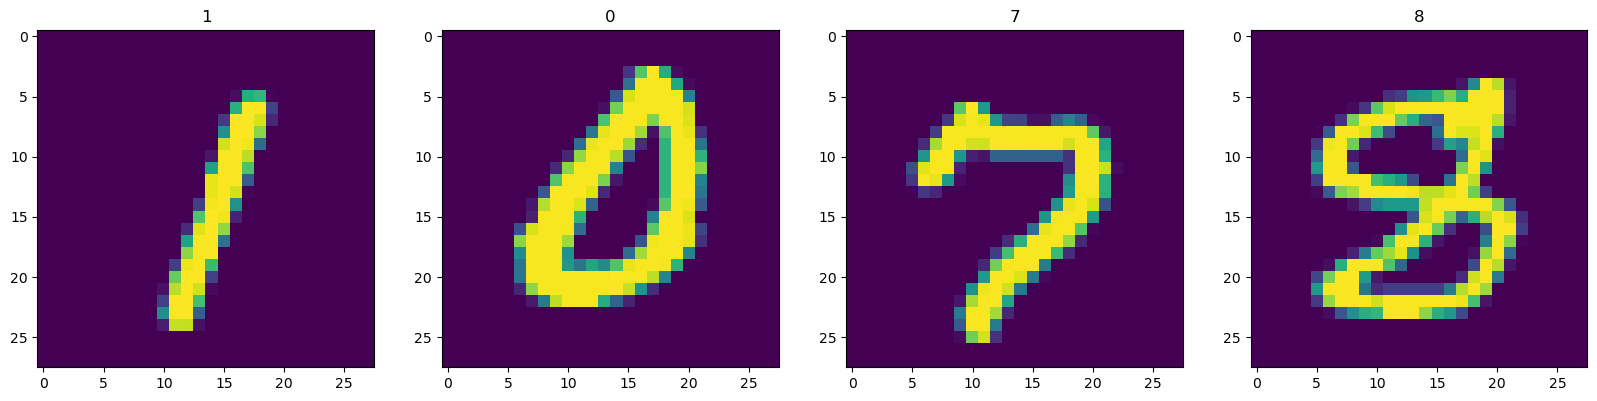

In [10]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20)) 

for idx in range(4): 
    sample = dataiterator.next() 
    ax[idx].imshow(np.squeeze(sample['image'])) 
    ax[idx].title.set_text(sample['label'])
plt.savefig('images/images.png')

# Building models


In [11]:
def scale_images(data): 
    image = data['image']
    return image / 255

In [12]:
ds = tfds.load('mnist', split='train')
ds = ds.map(scale_images) 
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(64) 
ds = ds.prefetch(64)

In [13]:
ds.as_numpy_iterator().next().shape

(64, 28, 28, 1)

In [14]:
def build_generator(): 
    model = Sequential()
    
    model.add(Dense(7*7*64, input_dim=100))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,64)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model


In [15]:
generator = build_generator()

In [16]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3136)              316736    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 4s 4s/step


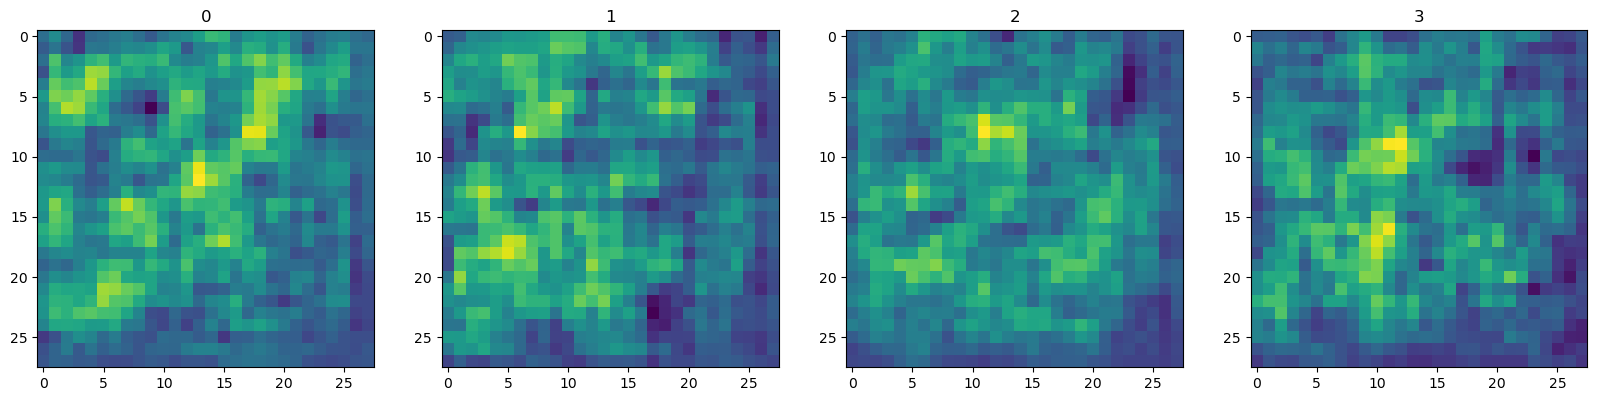

In [17]:
img = generator.predict(np.random.randn(4,100,1)) 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx, img in enumerate(img): 
    ax[idx].imshow(np.squeeze(img.reshape(28,28,1)))
    ax[idx].title.set_text(idx)
    
plt.savefig('images/gen_images1.png')

In [18]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model
    

In [19]:
discriminator = build_discriminator()

In [20]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

# Creating training loop

In [21]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [22]:
class GAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
     # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((64, 100, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((64,100,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [23]:
gan = GAN(generator, discriminator)

In [24]:
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [25]:
class ModelMonitor(Callback):
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        #Image generation every 50 epochs
        if epoch % 50 == 0:
            #Creating latent space
            random_latent_vectors = tf.random.uniform((4, self.latent_dim,1))
            #Generating images based on latent space and model form actual epoch
            generated_images = self.model.generator(random_latent_vectors)
            #Preparing images to plot
            generated_images *= 255.0
            generated_images.numpy()
            #Plotting and saving generated images
            fig, ax = plt.subplots(ncols=4, figsize=(20,20))
            for idx, img in enumerate(generated_images): 
                ax[idx].imshow(img)
            name = 'gen_images/sample_images_'+str(epoch)+'.png'
            plt.savefig(name)

In [26]:
if not os.path.exists('gen_images'):
    os.makedirs('gen_images')

# Training 

Epoch 1/2000
938/938 [==============================] - 124s 128ms/step - d_loss: 0.4334 - g_loss: 1.3875
Epoch 2/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.2688 - g_loss: 2.5898
Epoch 3/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.2678 - g_loss: 2.6115
Epoch 4/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.2675 - g_loss: 2.6456
Epoch 5/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.2668 - g_loss: 2.6874
Epoch 6/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.2670 - g_loss: 2.7168
Epoch 7/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.2674 - g_loss: 2.7345
Epoch 8/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.2732 - g_loss: 2.8286
Epoch 9/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.2677 - g_loss: 2.6772
Epoch 10/2000
938/938 [=======================

938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6876
Epoch 154/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6880
Epoch 155/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6876
Epoch 156/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6880
Epoch 157/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6880
Epoch 158/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6875
Epoch 159/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6876
Epoch 160/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6876
Epoch 161/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6880
Epoch 162/2000
938/938 [===================

Epoch 229/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6877
Epoch 230/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6880
Epoch 231/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6881
Epoch 232/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6884
Epoch 233/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6882
Epoch 234/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6883
Epoch 235/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6883
Epoch 236/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6882
Epoch 237/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6872
Epoch 238/2000
938/938 [====

Epoch 380/2000
938/938 [==============================] - 124s 132ms/step - d_loss: 0.6932 - g_loss: 0.6858
Epoch 381/2000
938/938 [==============================] - 125s 133ms/step - d_loss: 0.6932 - g_loss: 0.6854
Epoch 382/2000
938/938 [==============================] - 125s 133ms/step - d_loss: 0.6932 - g_loss: 0.6850
Epoch 383/2000
938/938 [==============================] - 126s 134ms/step - d_loss: 0.6932 - g_loss: 0.6853
Epoch 384/2000
938/938 [==============================] - 126s 135ms/step - d_loss: 0.6932 - g_loss: 0.6854
Epoch 385/2000
938/938 [==============================] - 125s 133ms/step - d_loss: 0.6932 - g_loss: 0.6855
Epoch 386/2000
938/938 [==============================] - 125s 133ms/step - d_loss: 0.6931 - g_loss: 0.6857
Epoch 387/2000
938/938 [==============================] - 125s 133ms/step - d_loss: 0.6932 - g_loss: 0.6858
Epoch 388/2000
938/938 [==============================] - 123s 132ms/step - d_loss: 0.6932 - g_loss: 0.6857
Epoch 389/2000
938/938 [====

Epoch 531/2000
938/938 [==============================] - 118s 126ms/step - d_loss: 0.6932 - g_loss: 0.6847
Epoch 532/2000
938/938 [==============================] - 119s 126ms/step - d_loss: 0.6932 - g_loss: 0.6848
Epoch 533/2000
938/938 [==============================] - 119s 126ms/step - d_loss: 0.6932 - g_loss: 0.6848
Epoch 534/2000
938/938 [==============================] - 118s 126ms/step - d_loss: 0.6932 - g_loss: 0.6849
Epoch 535/2000
938/938 [==============================] - 119s 126ms/step - d_loss: 0.6932 - g_loss: 0.6847
Epoch 536/2000
938/938 [==============================] - 119s 126ms/step - d_loss: 0.6932 - g_loss: 0.6849
Epoch 537/2000
938/938 [==============================] - 119s 126ms/step - d_loss: 0.6932 - g_loss: 0.6852
Epoch 538/2000
938/938 [==============================] - 119s 126ms/step - d_loss: 0.6932 - g_loss: 0.6847
Epoch 539/2000
938/938 [==============================] - 118s 126ms/step - d_loss: 0.6932 - g_loss: 0.6849
Epoch 540/2000
938/938 [====

Epoch 682/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.6932 - g_loss: 0.6823
Epoch 683/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.6932 - g_loss: 0.6821
Epoch 684/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.6932 - g_loss: 0.6825
Epoch 685/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.6932 - g_loss: 0.6830
Epoch 686/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.6932 - g_loss: 0.6823
Epoch 687/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.6932 - g_loss: 0.6824
Epoch 688/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6826
Epoch 689/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6824
Epoch 690/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6931 - g_loss: 0.6827
Epoch 691/2000
938/938 [====

Epoch 833/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6933 - g_loss: 0.6796
Epoch 834/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6933 - g_loss: 0.6814
Epoch 835/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6933 - g_loss: 0.6816
Epoch 836/2000
938/938 [==============================] - 119s 126ms/step - d_loss: 0.6933 - g_loss: 0.6829
Epoch 837/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6933 - g_loss: 0.6838
Epoch 838/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6933 - g_loss: 0.6836
Epoch 839/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6933 - g_loss: 0.6836
Epoch 840/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6841
Epoch 841/2000
938/938 [==============================] - 119s 126ms/step - d_loss: 0.6932 - g_loss: 0.6850
Epoch 842/2000
938/938 [====

Epoch 984/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6933 - g_loss: 0.6395
Epoch 985/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.6934 - g_loss: 0.6465
Epoch 986/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.6928 - g_loss: 0.6474
Epoch 987/2000
938/938 [==============================] - 123s 131ms/step - d_loss: 0.6935 - g_loss: 0.6410
Epoch 988/2000
938/938 [==============================] - 122s 130ms/step - d_loss: 0.6938 - g_loss: 0.6571
Epoch 989/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.6907 - g_loss: 0.6756
Epoch 990/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.2892 - g_loss: 0.6033
Epoch 991/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.2754 - g_loss: 0.4424
Epoch 992/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.2807 - g_loss: 0.3051
Epoch 993/2000
938/938 [====

C:\Users\slawo\AppData\Local\Temp\ipykernel_36320\1014130867.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(ncols=4, figsize=(20,20))


938/938 [==============================] - 126s 135ms/step - d_loss: 0.6940 - g_loss: 0.6179
Epoch 1002/2000
938/938 [==============================] - 122s 130ms/step - d_loss: 0.6935 - g_loss: 0.6311
Epoch 1003/2000
938/938 [==============================] - 121s 129ms/step - d_loss: 0.6945 - g_loss: 0.6348
Epoch 1004/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.6941 - g_loss: 0.6640
Epoch 1005/2000
938/938 [==============================] - 123s 131ms/step - d_loss: 0.6936 - g_loss: 0.6557
Epoch 1006/2000
938/938 [==============================] - 123s 131ms/step - d_loss: 0.6936 - g_loss: 0.6391
Epoch 1007/2000
938/938 [==============================] - 123s 131ms/step - d_loss: 0.6935 - g_loss: 0.6359
Epoch 1008/2000
938/938 [==============================] - 124s 132ms/step - d_loss: 0.6915 - g_loss: 0.6128
Epoch 1009/2000
938/938 [==============================] - 124s 132ms/step - d_loss: 0.6936 - g_loss: 0.6342
Epoch 1010/2000
938/938 [==========

938/938 [==============================] - 119s 127ms/step - d_loss: 0.6933 - g_loss: 0.6782
Epoch 1152/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6933 - g_loss: 0.6781
Epoch 1153/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6933 - g_loss: 0.6784
Epoch 1154/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6798
Epoch 1155/2000
938/938 [==============================] - 123s 131ms/step - d_loss: 0.6933 - g_loss: 0.6771
Epoch 1156/2000
938/938 [==============================] - 122s 130ms/step - d_loss: 0.6933 - g_loss: 0.6784
Epoch 1157/2000
938/938 [==============================] - 122s 130ms/step - d_loss: 0.6932 - g_loss: 0.6780
Epoch 1158/2000
938/938 [==============================] - 122s 131ms/step - d_loss: 0.6932 - g_loss: 0.6782
Epoch 1159/2000
938/938 [==============================] - 123s 131ms/step - d_loss: 0.6933 - g_loss: 0.6776
Epoch 1160/2000
938/938 [==========

938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6774
Epoch 1302/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6780
Epoch 1303/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6769
Epoch 1304/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6767
Epoch 1305/2000
938/938 [==============================] - 121s 129ms/step - d_loss: 0.6932 - g_loss: 0.6773
Epoch 1306/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.6933 - g_loss: 0.6760
Epoch 1307/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.6931 - g_loss: 0.6744
Epoch 1308/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.6926 - g_loss: 0.6627
Epoch 1309/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.6933 - g_loss: 0.6531
Epoch 1310/2000
938/938 [==========

938/938 [==============================] - 120s 128ms/step - d_loss: 0.6930 - g_loss: 0.6699
Epoch 1452/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6931 - g_loss: 0.6642
Epoch 1453/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6928 - g_loss: 0.6701
Epoch 1454/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6929 - g_loss: 0.6497
Epoch 1455/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6934 - g_loss: 0.6590
Epoch 1456/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6930 - g_loss: 0.6703
Epoch 1457/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6767
Epoch 1458/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6933 - g_loss: 0.6694
Epoch 1459/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6933 - g_loss: 0.6759
Epoch 1460/2000
938/938 [==========

938/938 [==============================] - 122s 130ms/step - d_loss: 0.6932 - g_loss: 0.6782
Epoch 1602/2000
938/938 [==============================] - 122s 130ms/step - d_loss: 0.6932 - g_loss: 0.6780
Epoch 1603/2000
938/938 [==============================] - 122s 130ms/step - d_loss: 0.6932 - g_loss: 0.6785
Epoch 1604/2000
938/938 [==============================] - 123s 131ms/step - d_loss: 0.6932 - g_loss: 0.6773
Epoch 1605/2000
938/938 [==============================] - 126s 134ms/step - d_loss: 0.6932 - g_loss: 0.6735
Epoch 1606/2000
938/938 [==============================] - 124s 133ms/step - d_loss: 0.6932 - g_loss: 0.6732
Epoch 1607/2000
938/938 [==============================] - 124s 132ms/step - d_loss: 0.6932 - g_loss: 0.6752
Epoch 1608/2000
938/938 [==============================] - 123s 131ms/step - d_loss: 0.6932 - g_loss: 0.6736
Epoch 1609/2000
938/938 [==============================] - 123s 131ms/step - d_loss: 0.6932 - g_loss: 0.6718
Epoch 1610/2000
938/938 [==========

938/938 [==============================] - 120s 128ms/step - d_loss: 0.6932 - g_loss: 0.6781
Epoch 1752/2000
938/938 [==============================] - 120s 128ms/step - d_loss: 0.6932 - g_loss: 0.6771
Epoch 1753/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6782
Epoch 1754/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6775
Epoch 1755/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6775
Epoch 1756/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6771
Epoch 1757/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6776
Epoch 1758/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6781
Epoch 1759/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6780
Epoch 1760/2000
938/938 [==========

938/938 [==============================] - 120s 127ms/step - d_loss: 0.6932 - g_loss: 0.6796
Epoch 1902/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6799
Epoch 1903/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6800
Epoch 1904/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6795
Epoch 1905/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6797
Epoch 1906/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6799
Epoch 1907/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6795
Epoch 1908/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6794
Epoch 1909/2000
938/938 [==============================] - 119s 127ms/step - d_loss: 0.6932 - g_loss: 0.6797
Epoch 1910/2000
938/938 [==========

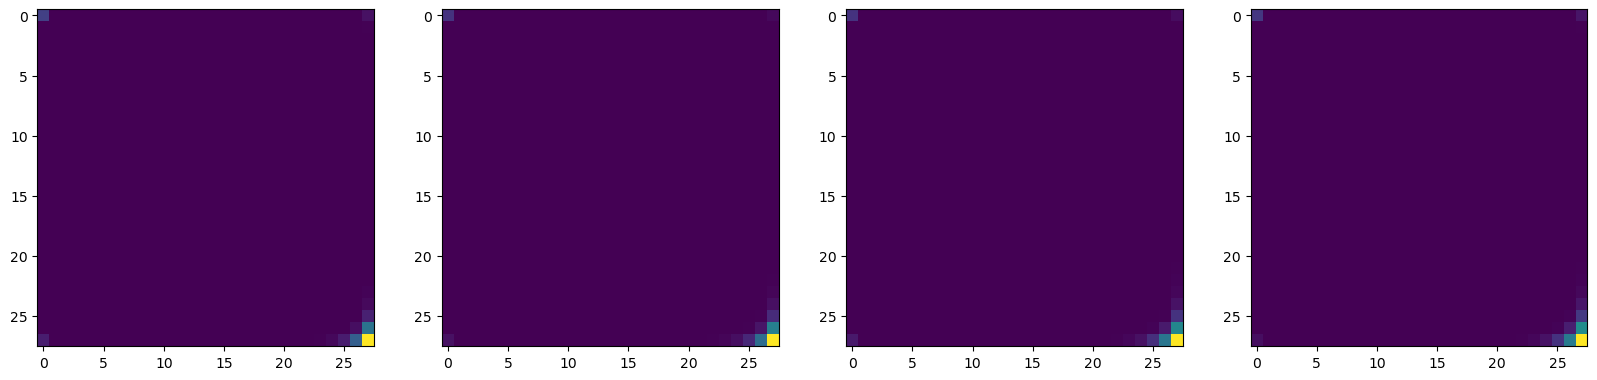

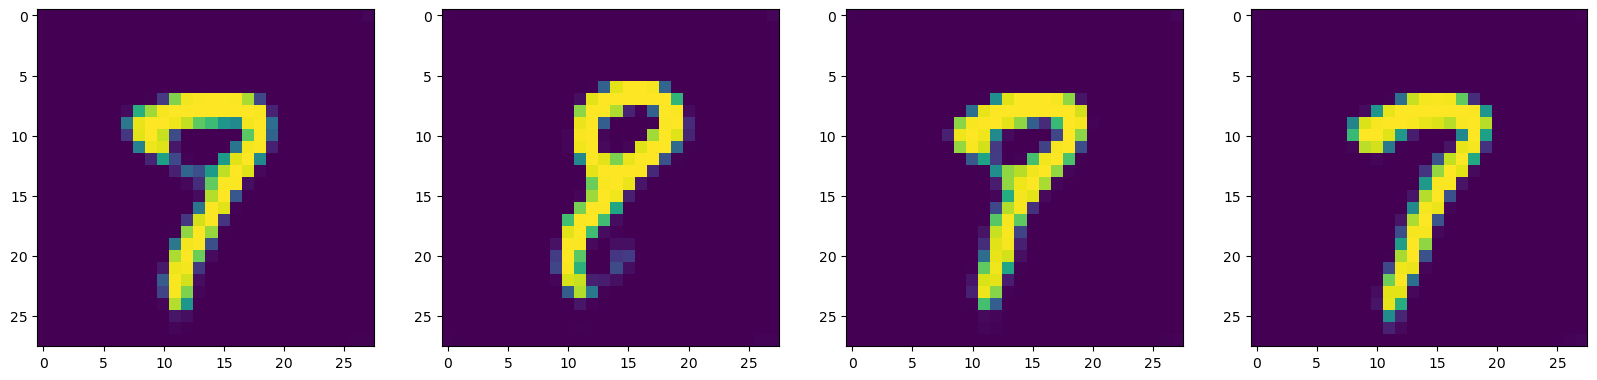

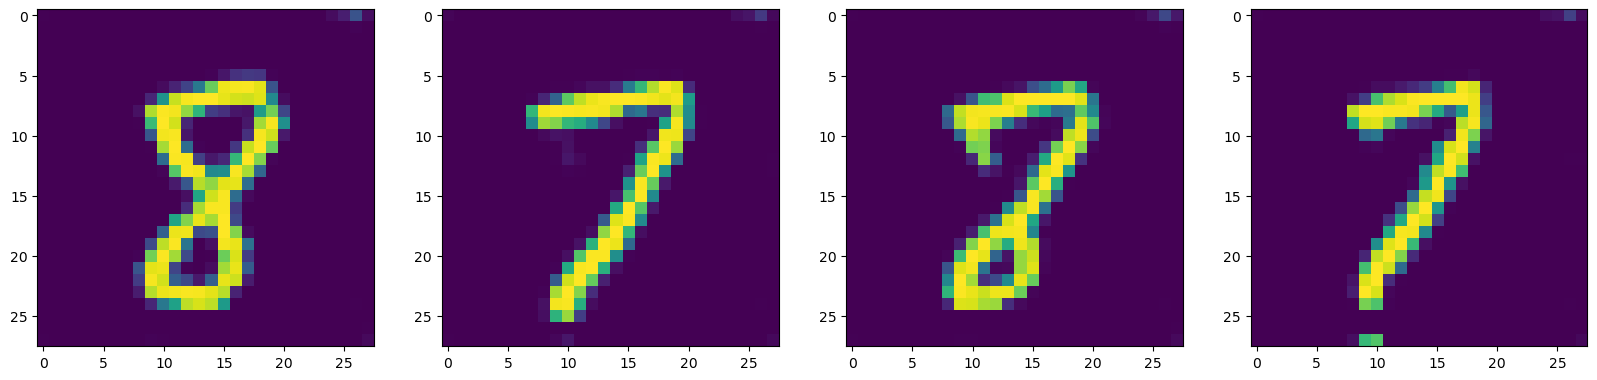

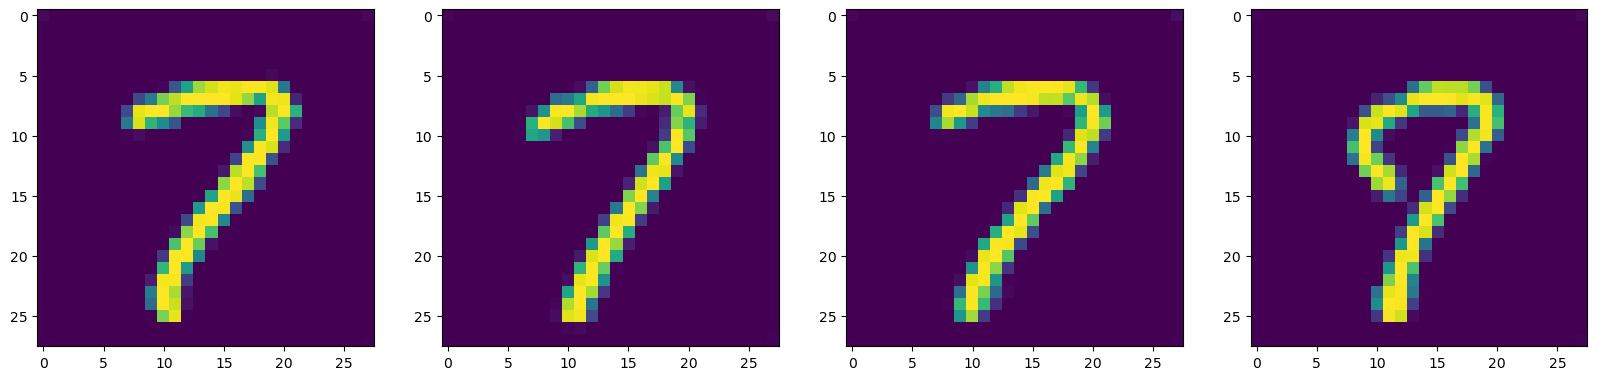

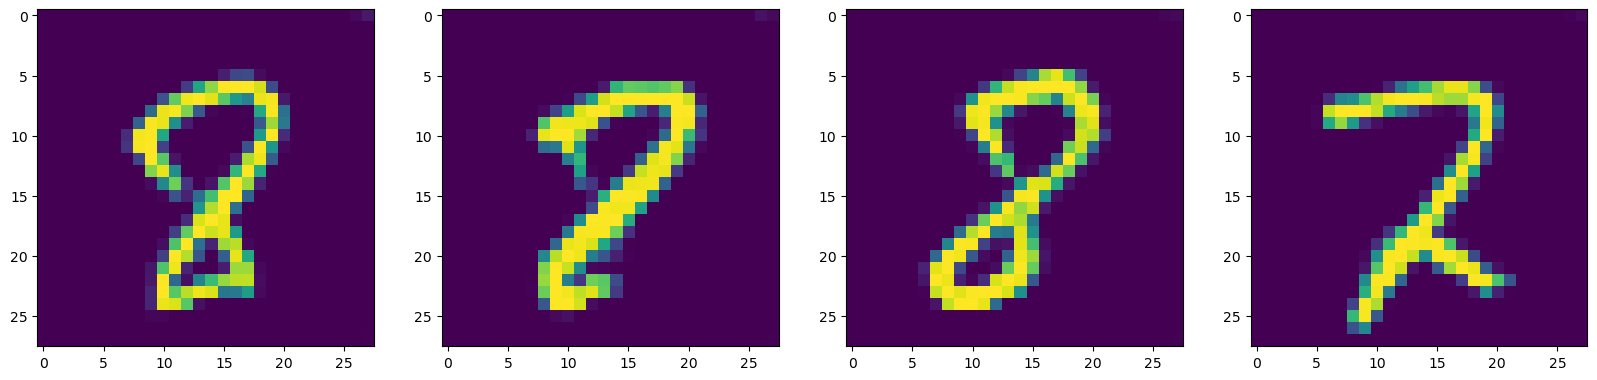

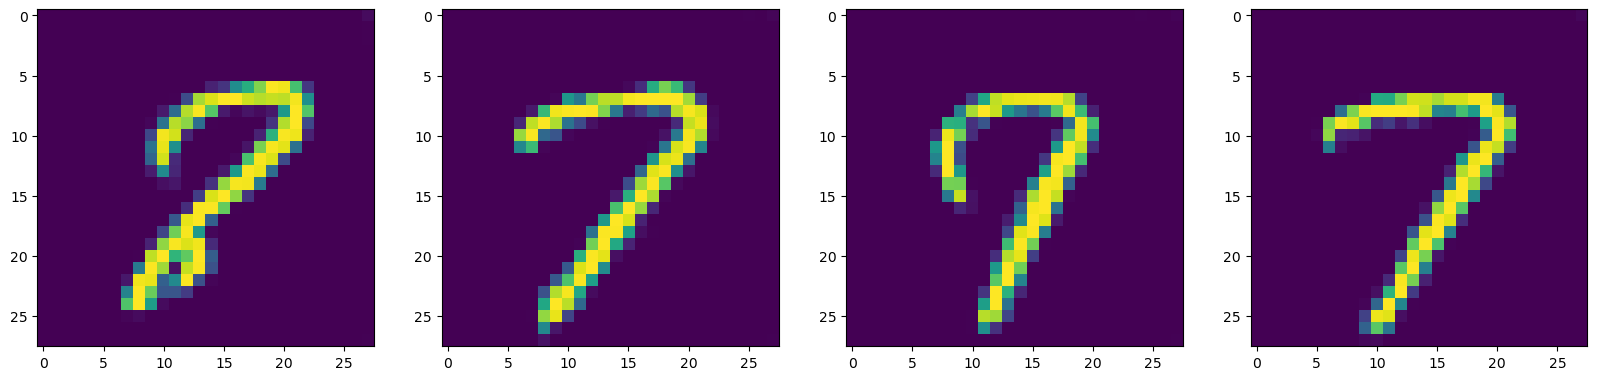

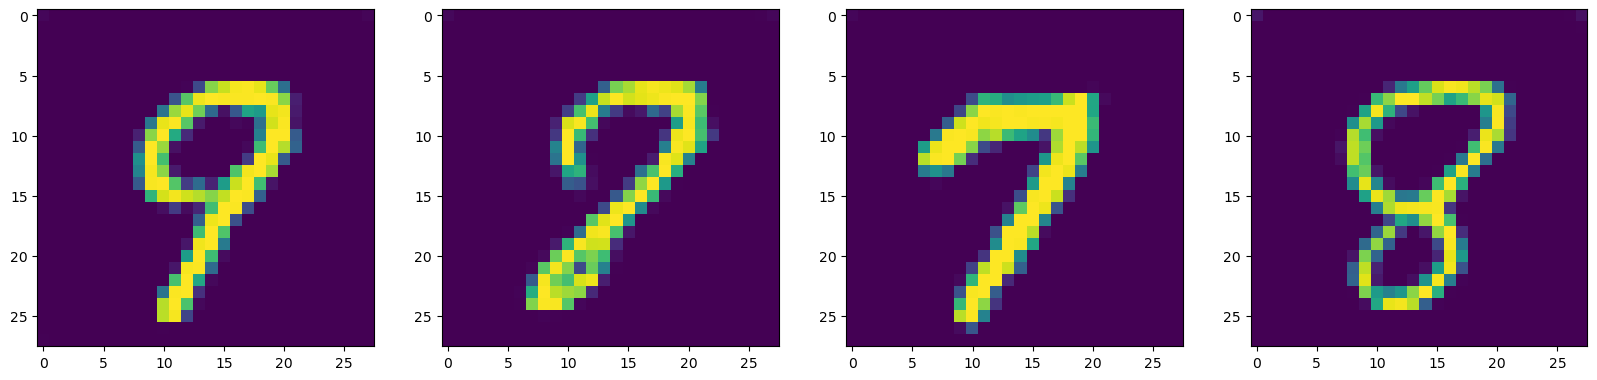

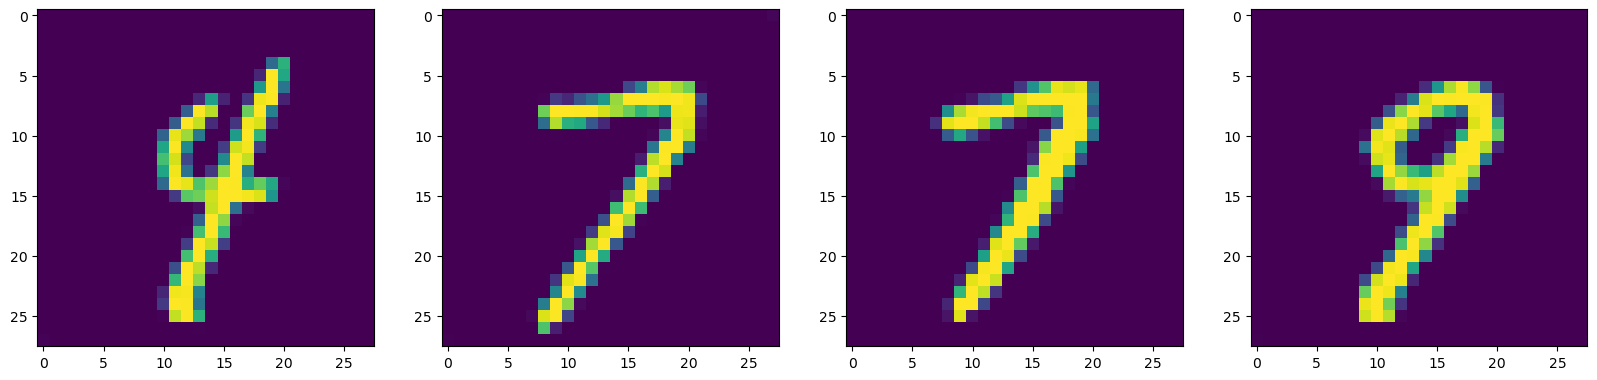

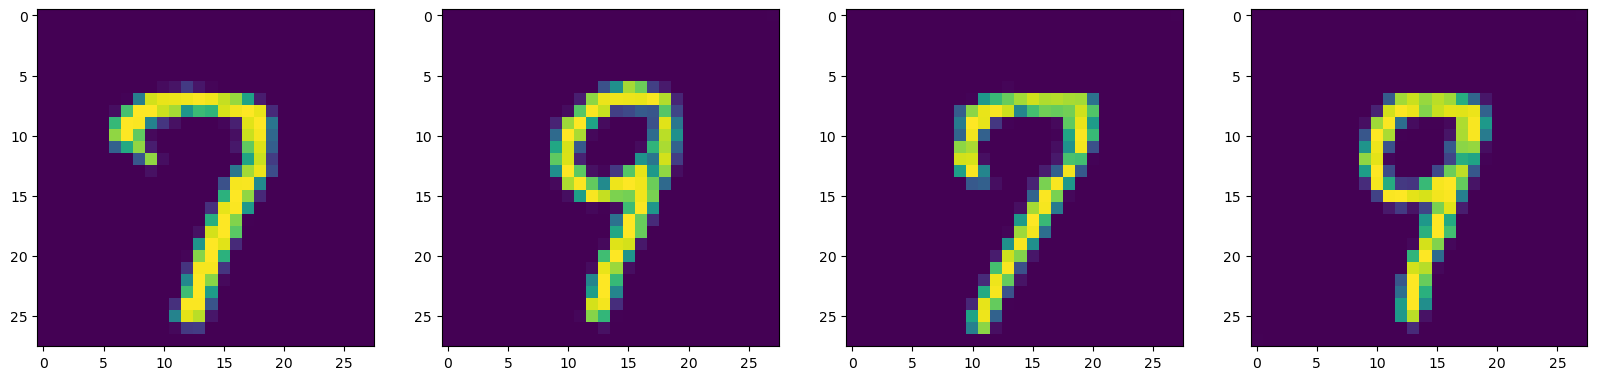

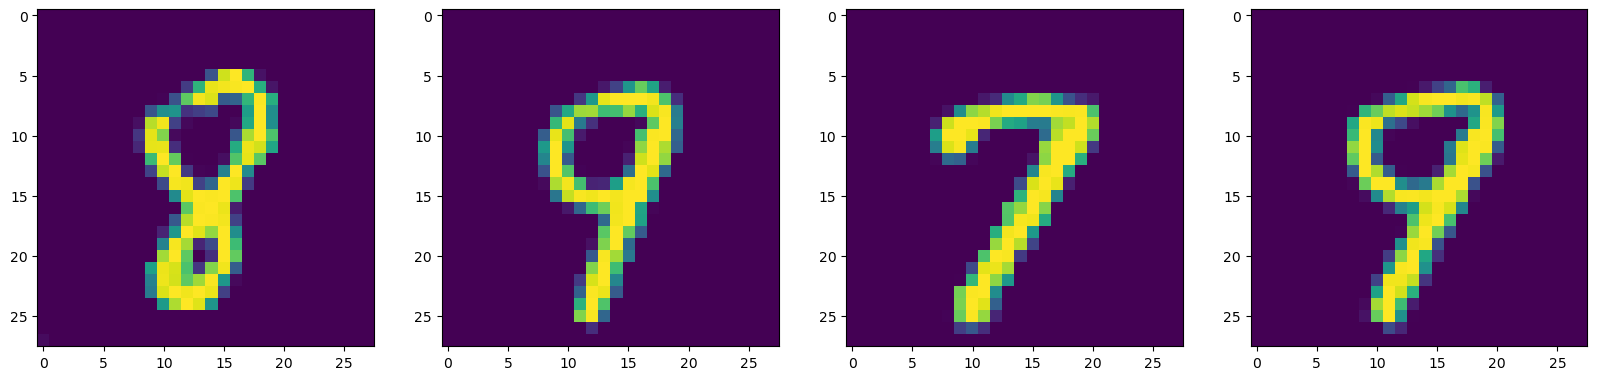

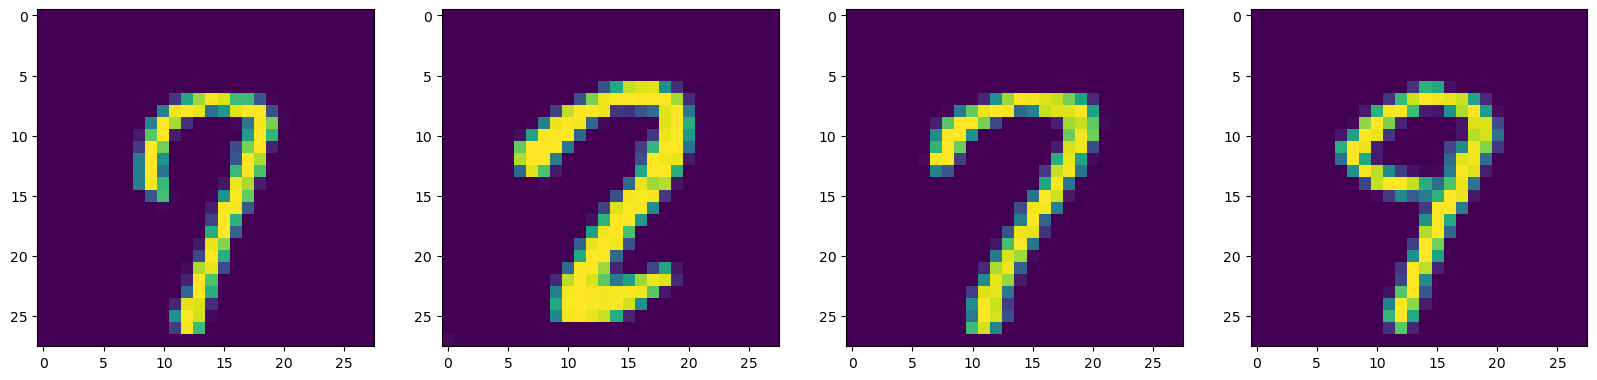

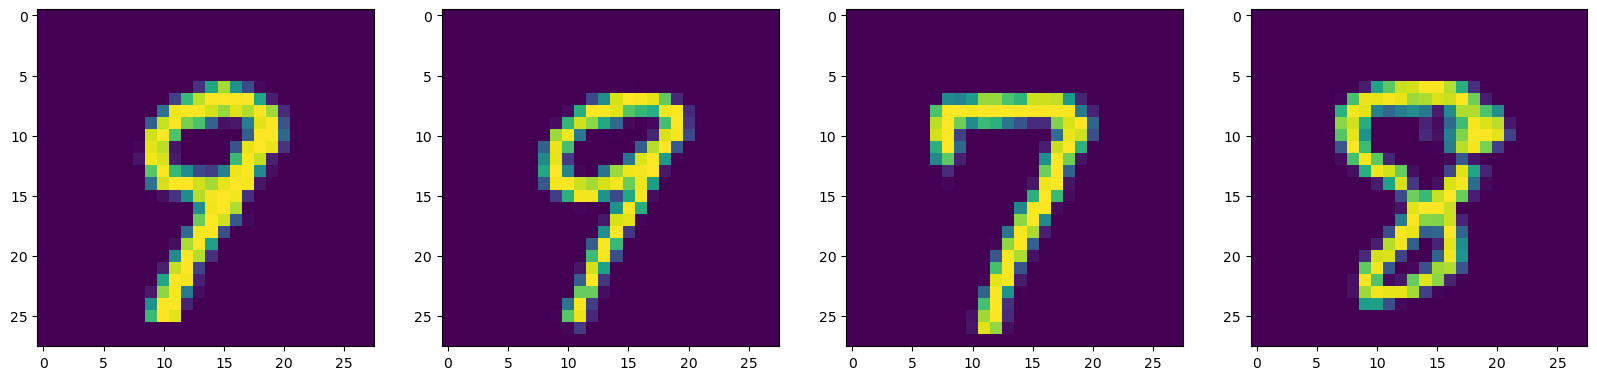

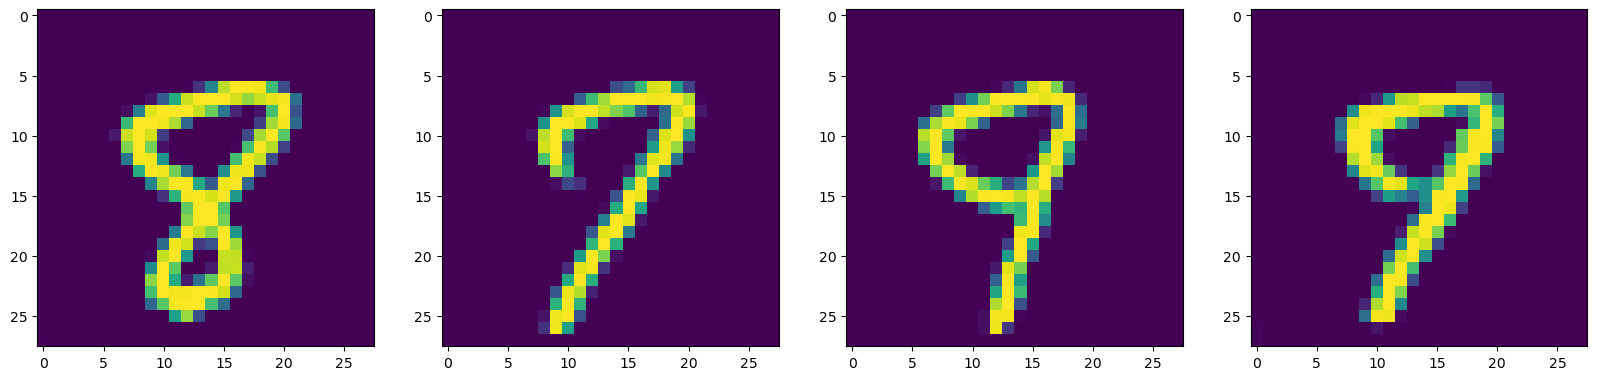

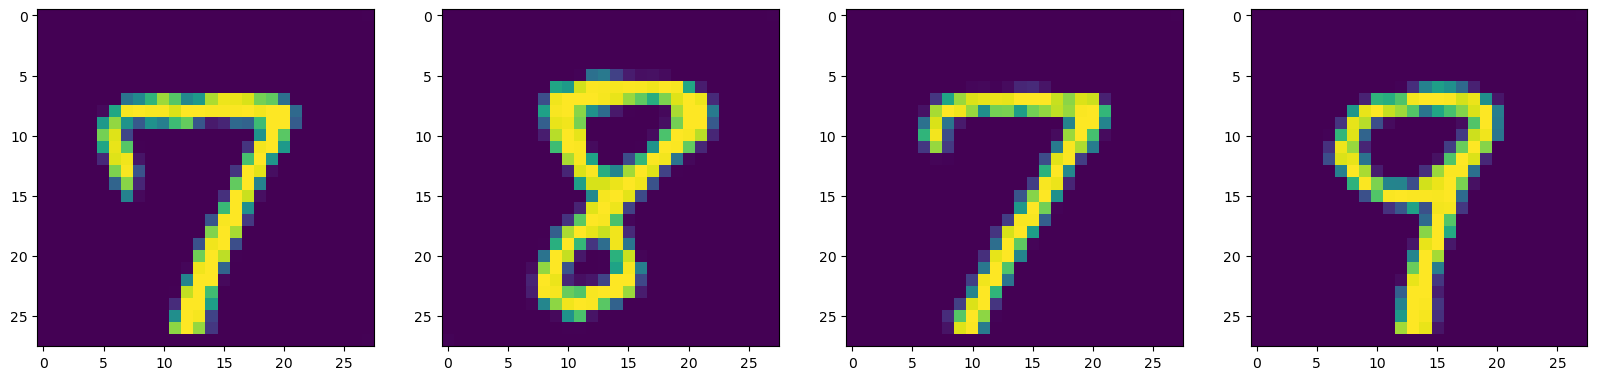

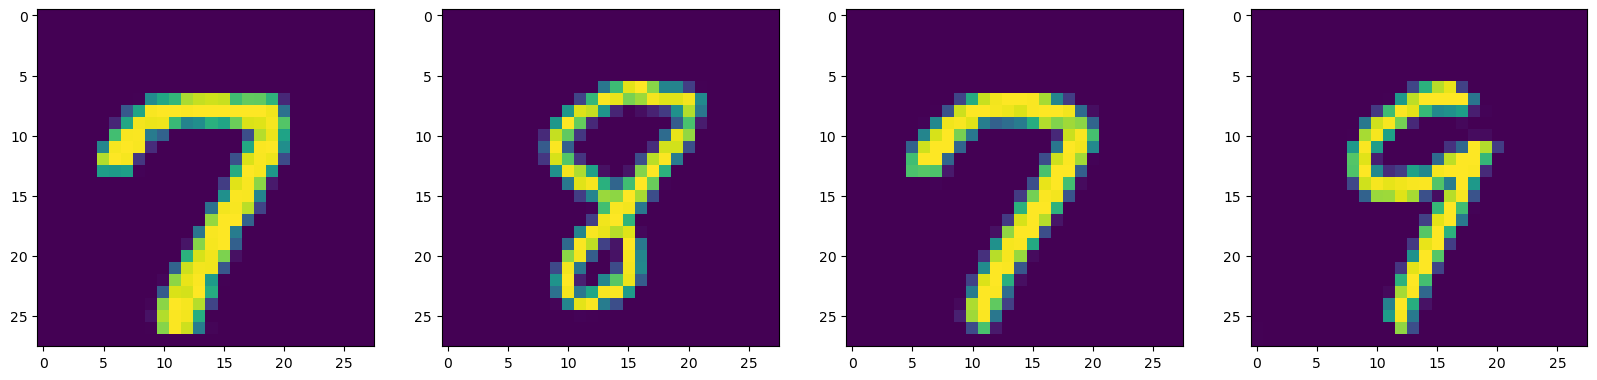

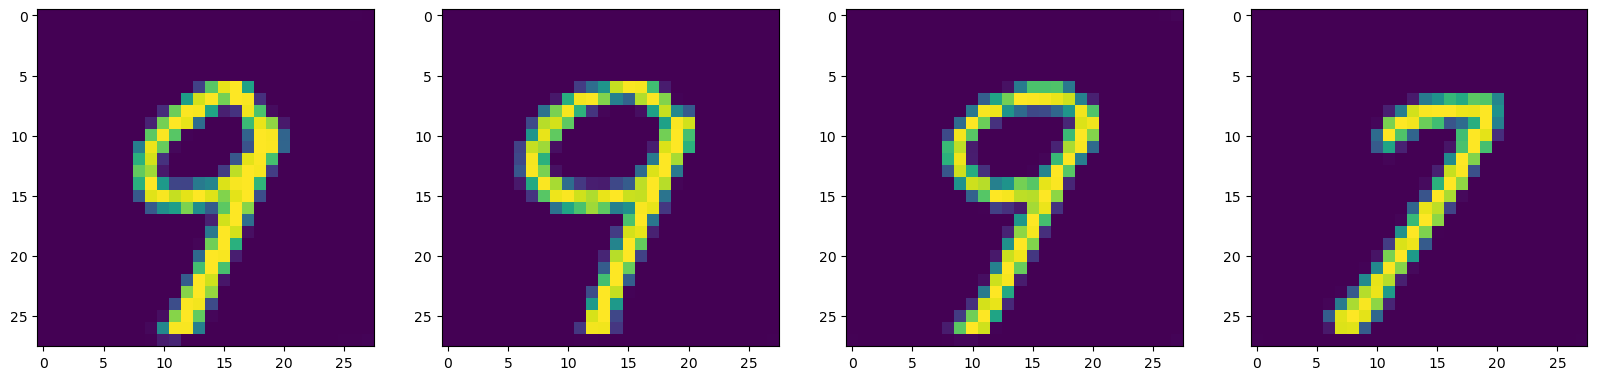

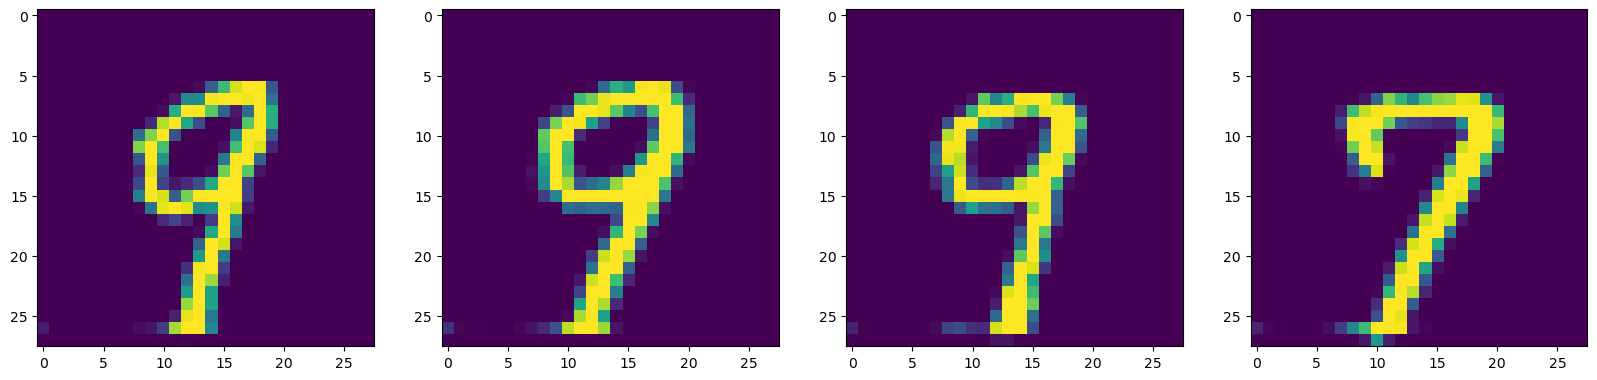

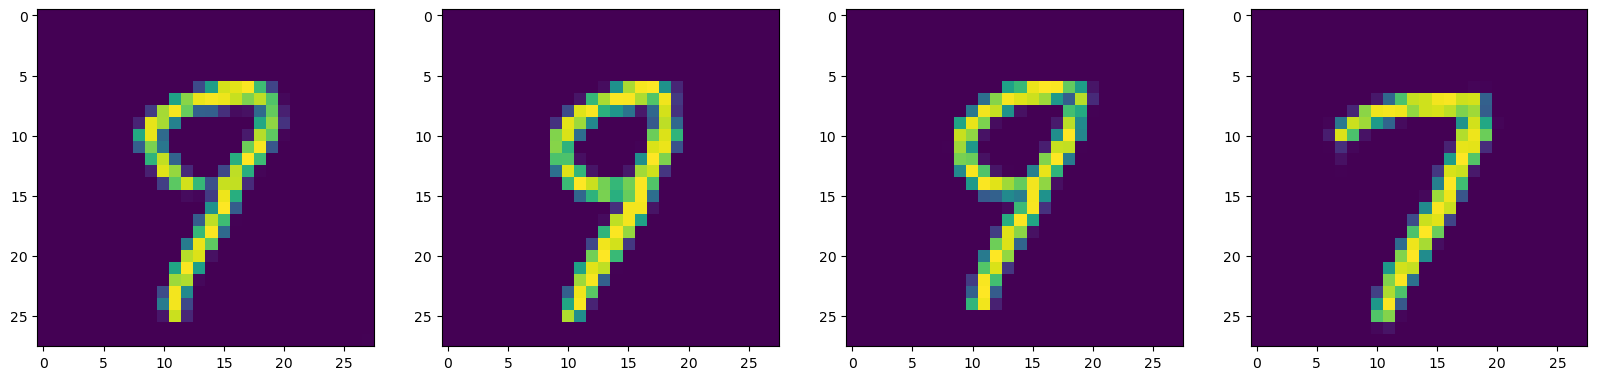

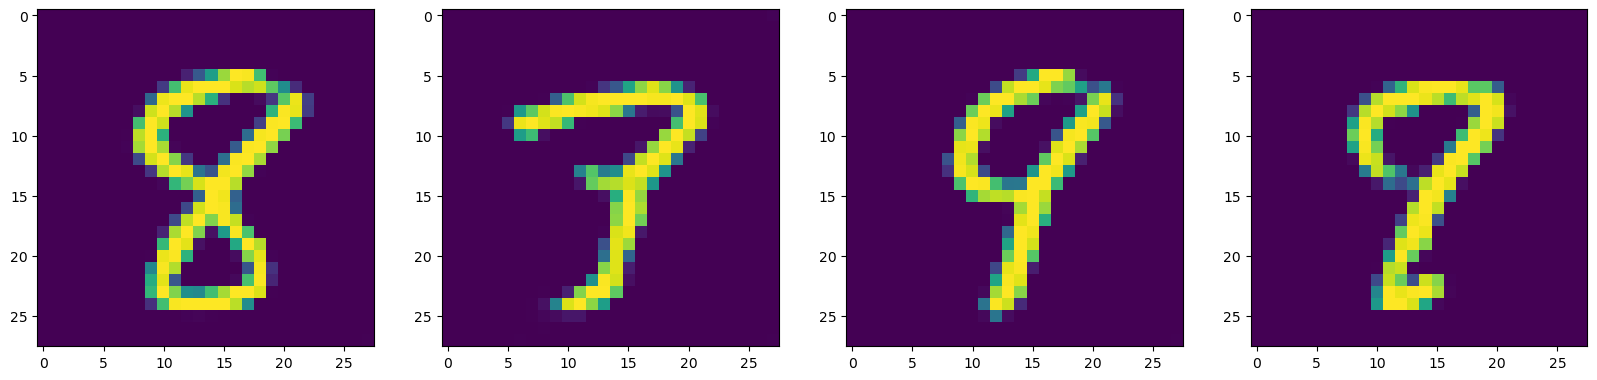

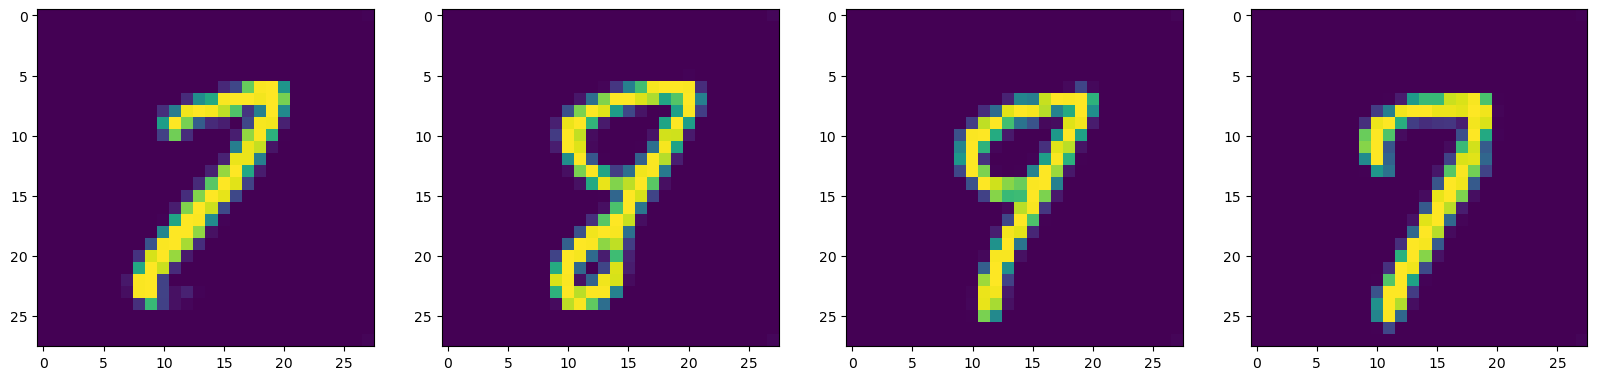

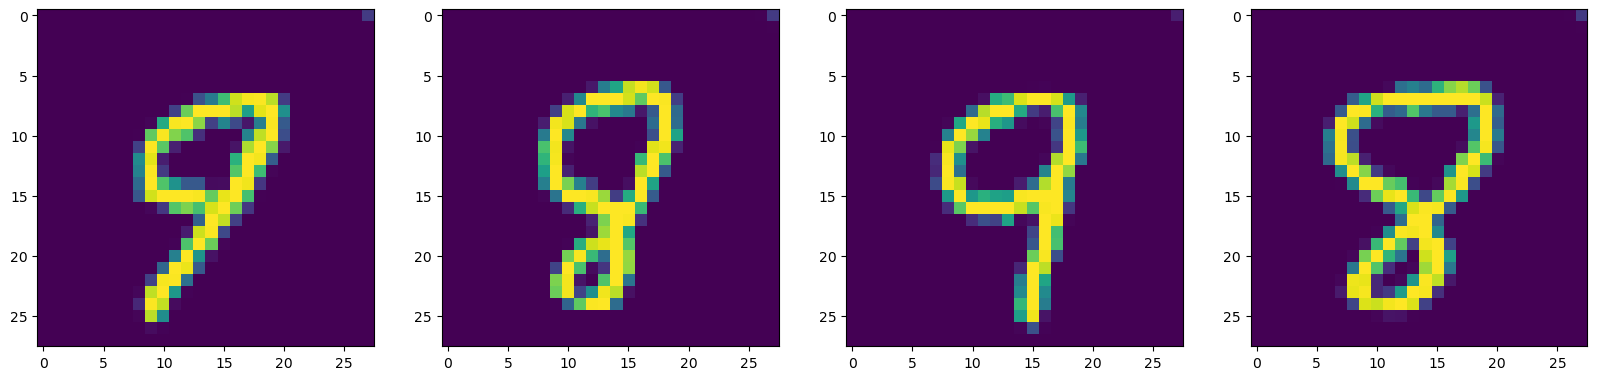

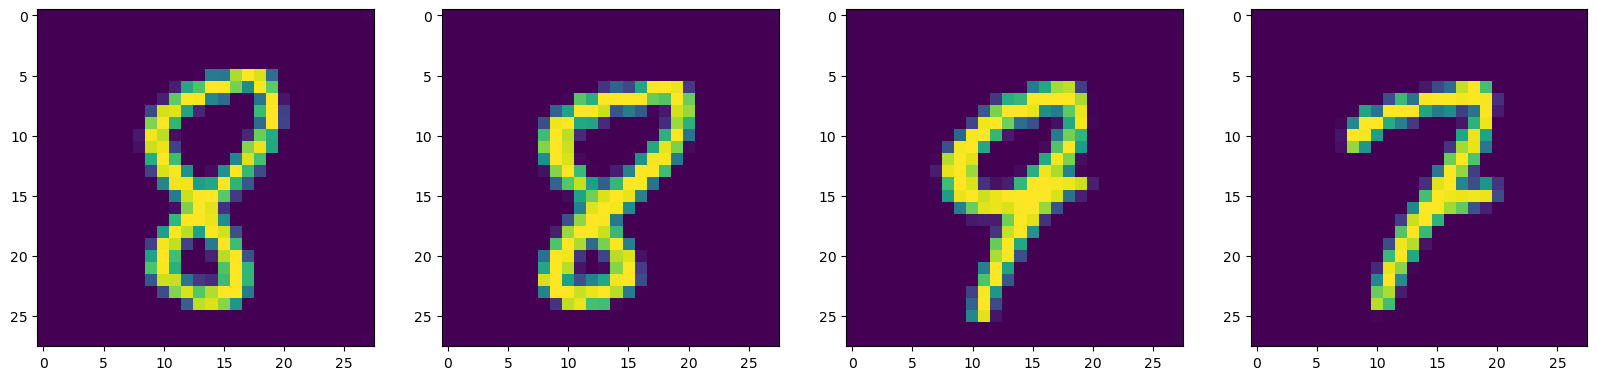

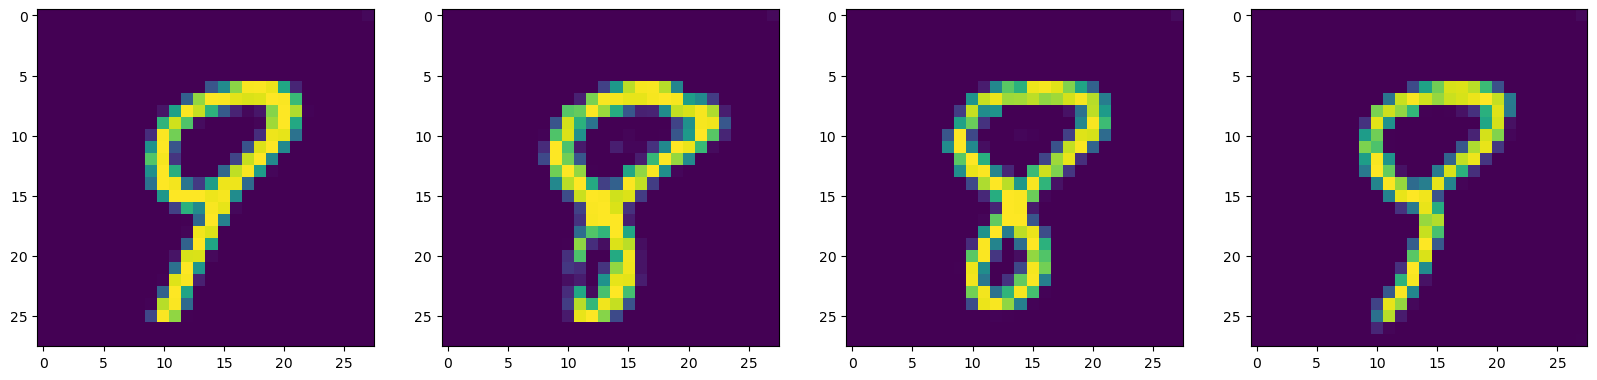

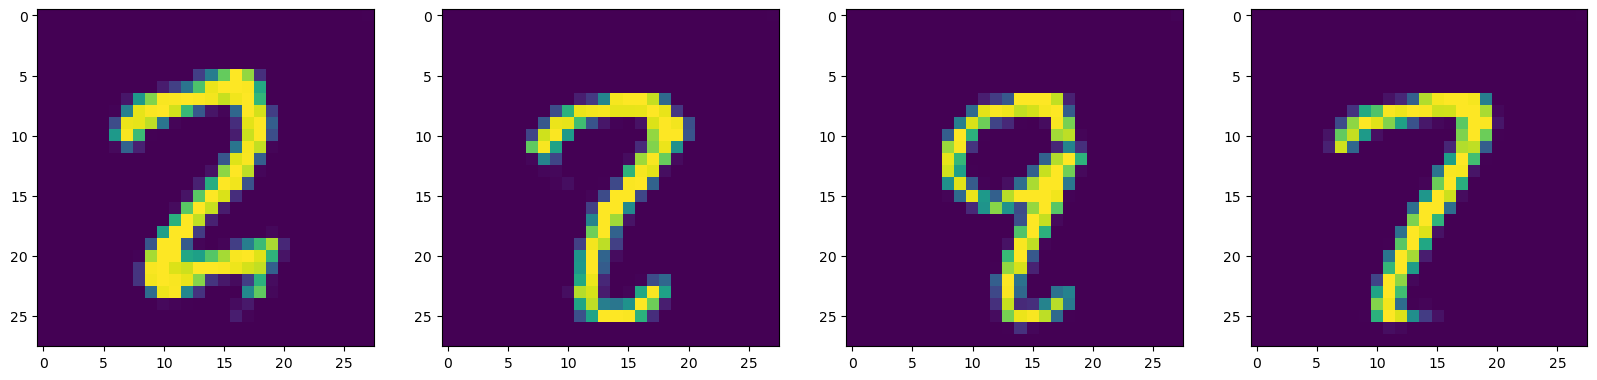

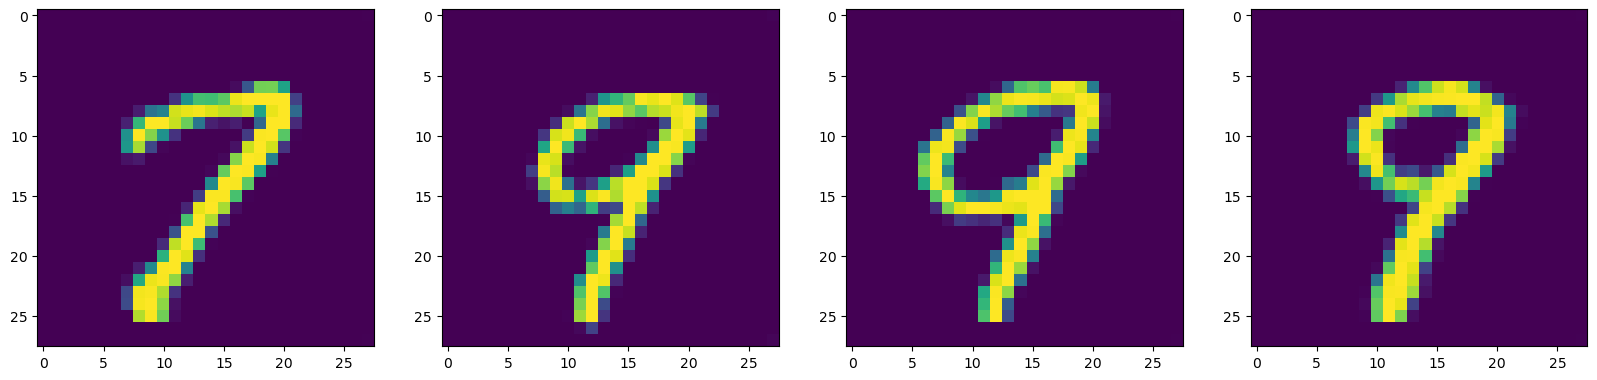

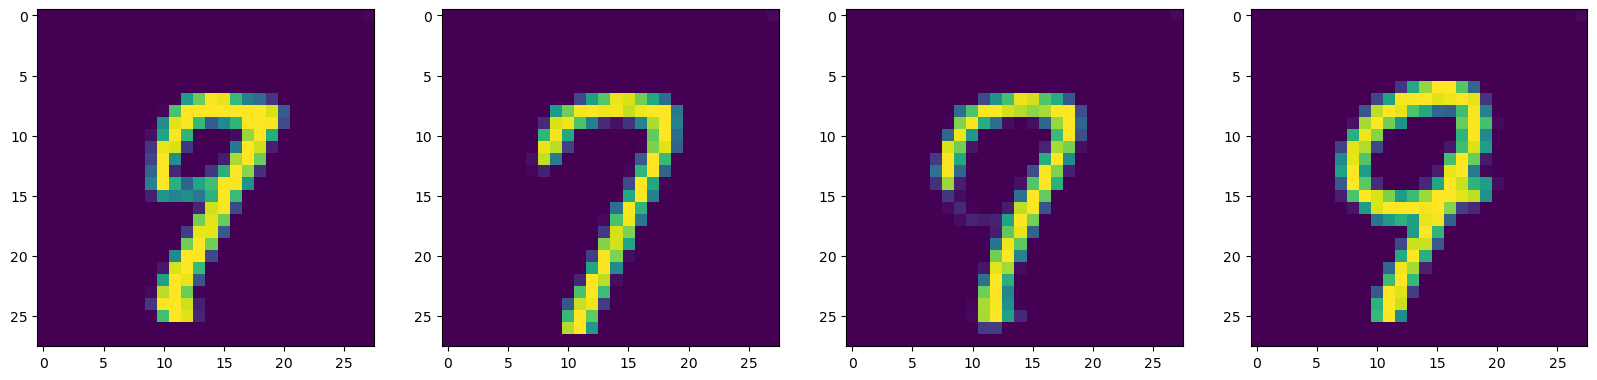

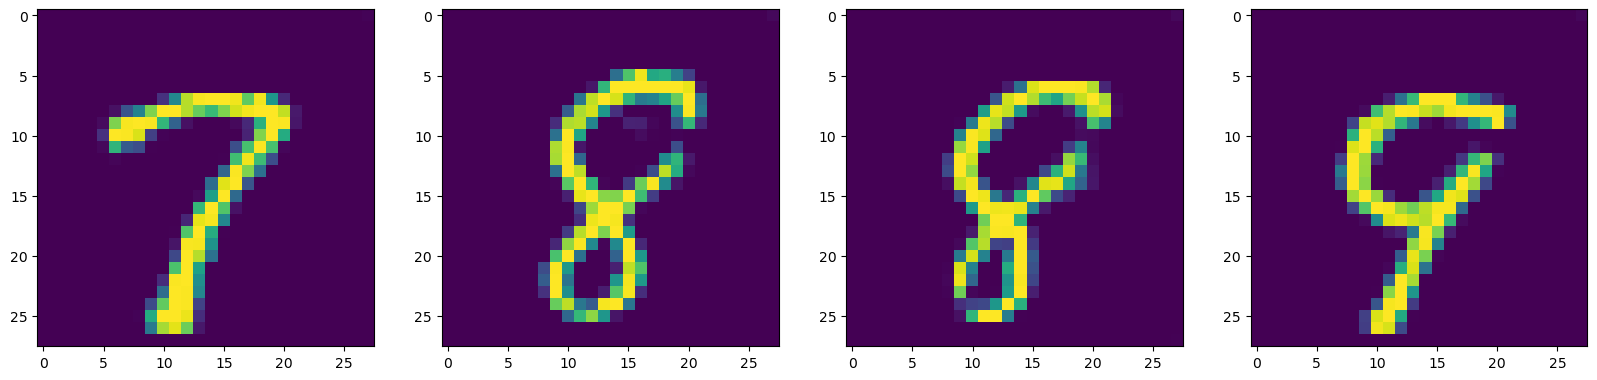

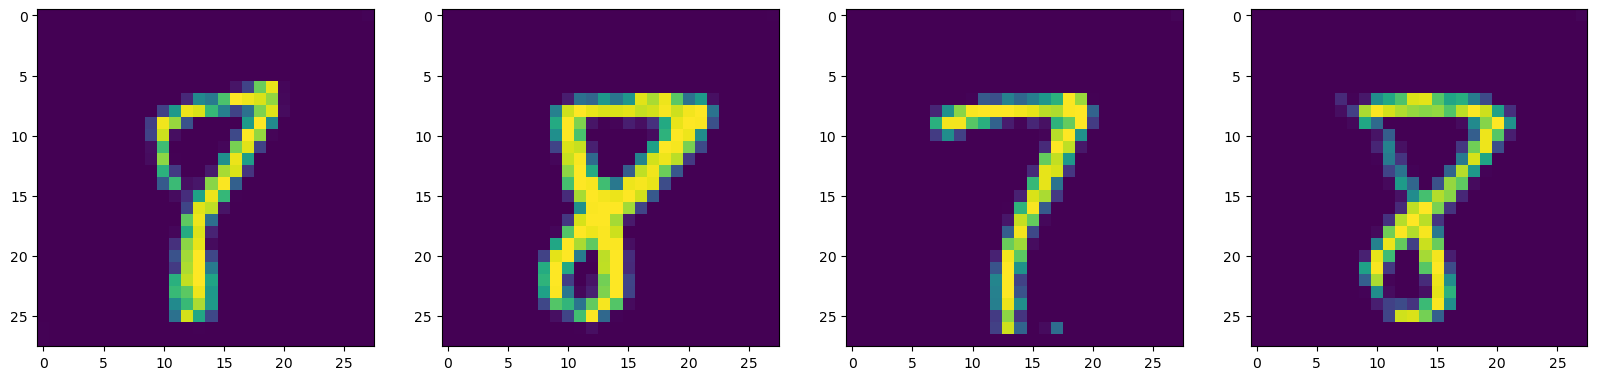

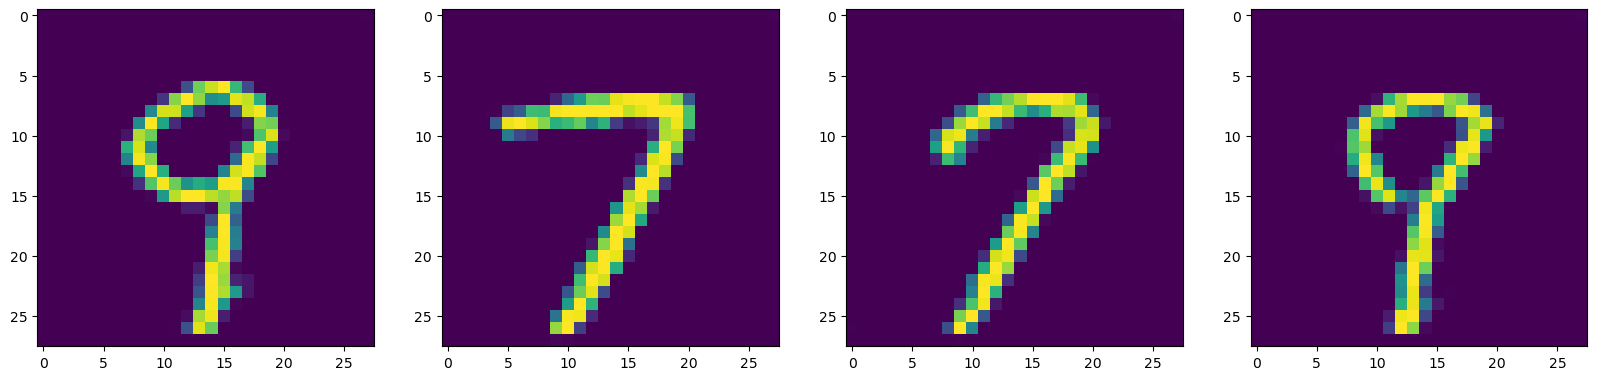

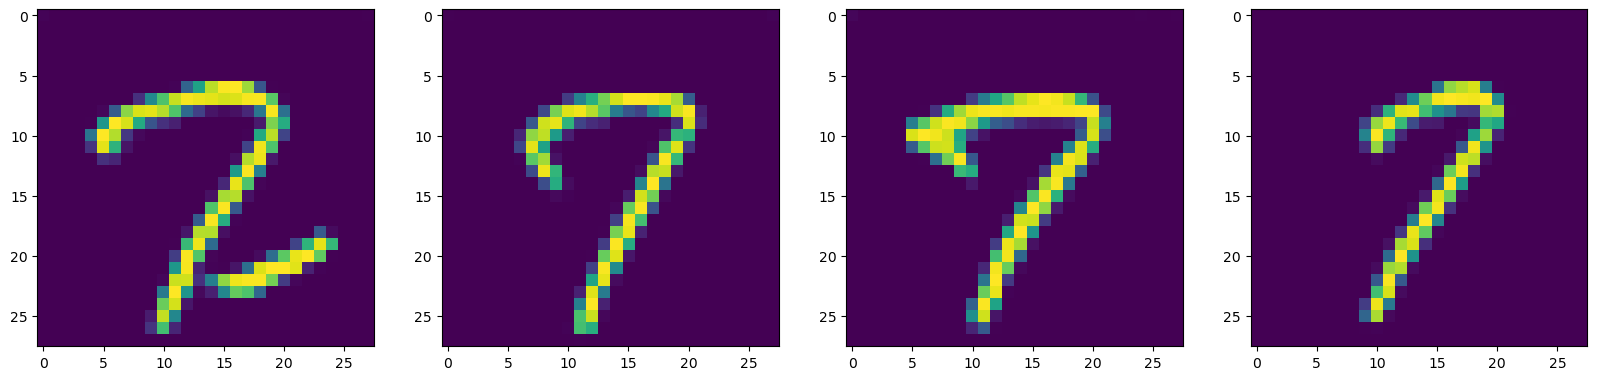

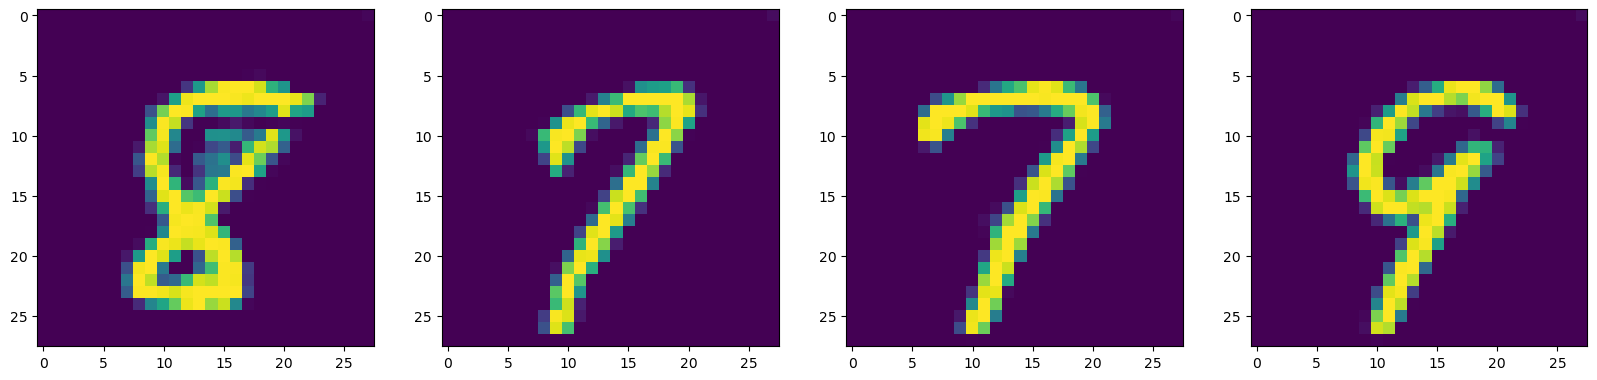

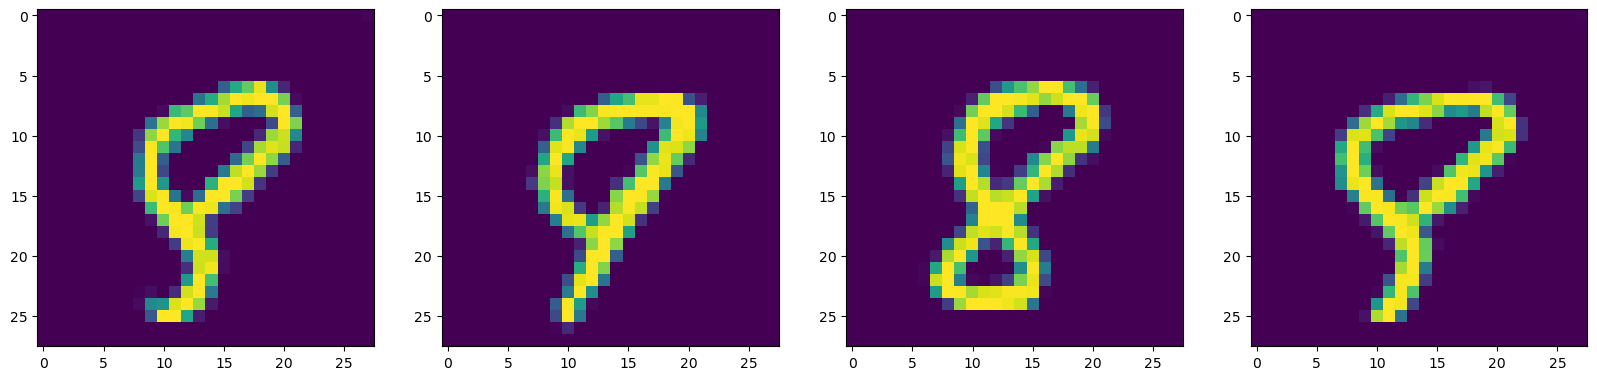

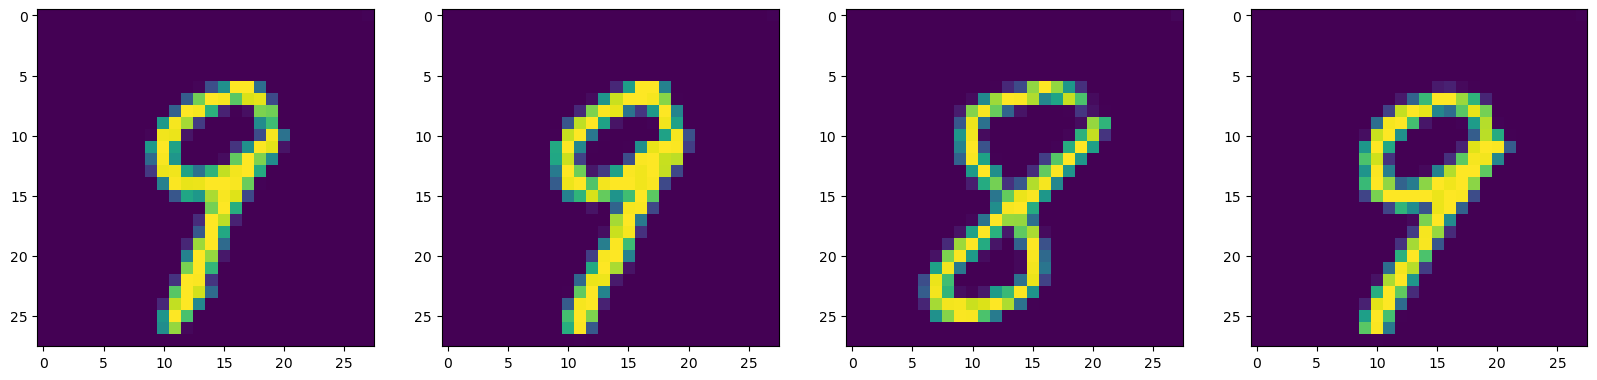

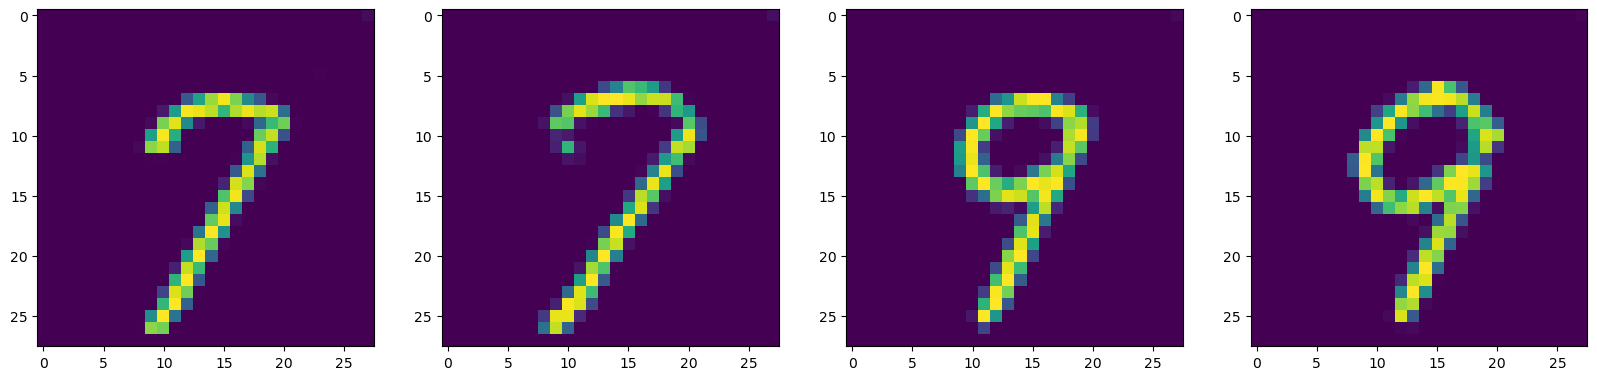

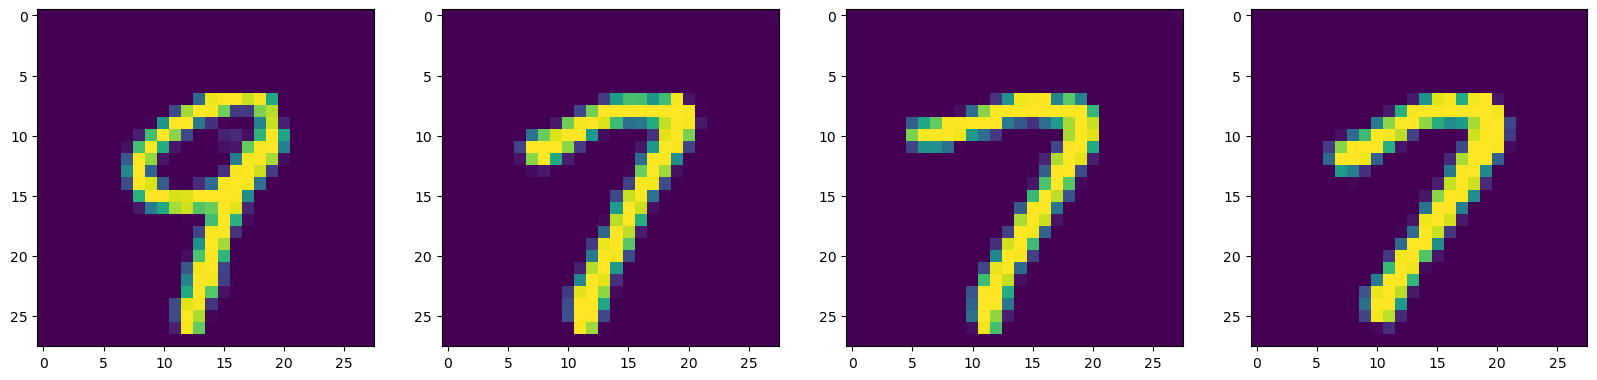

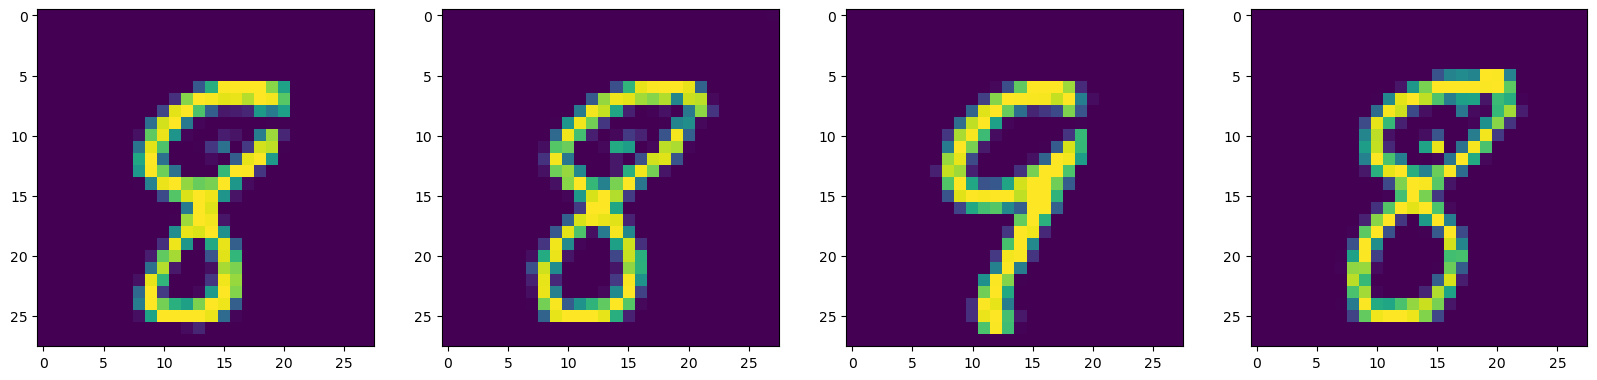

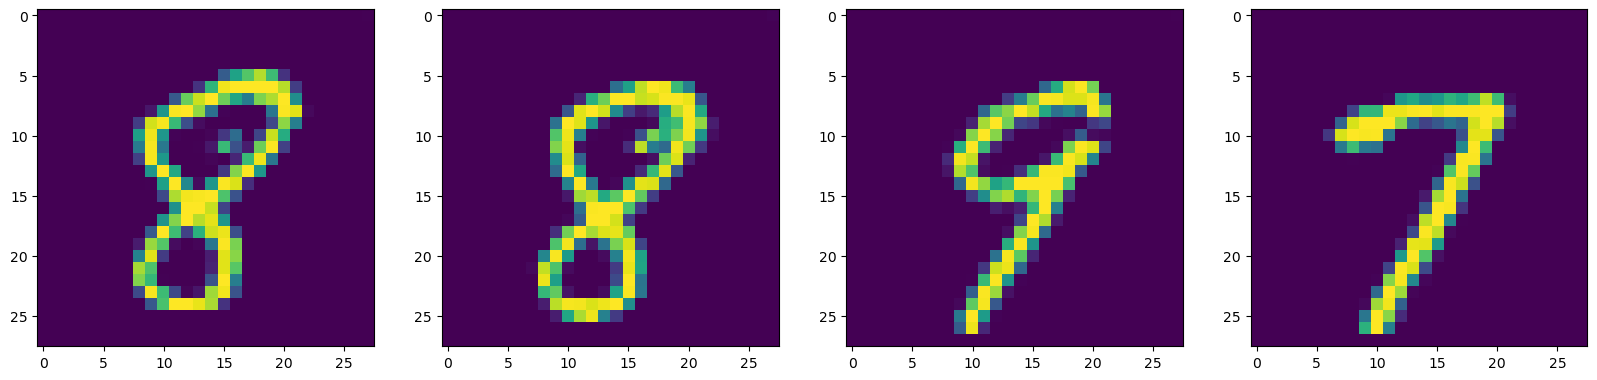

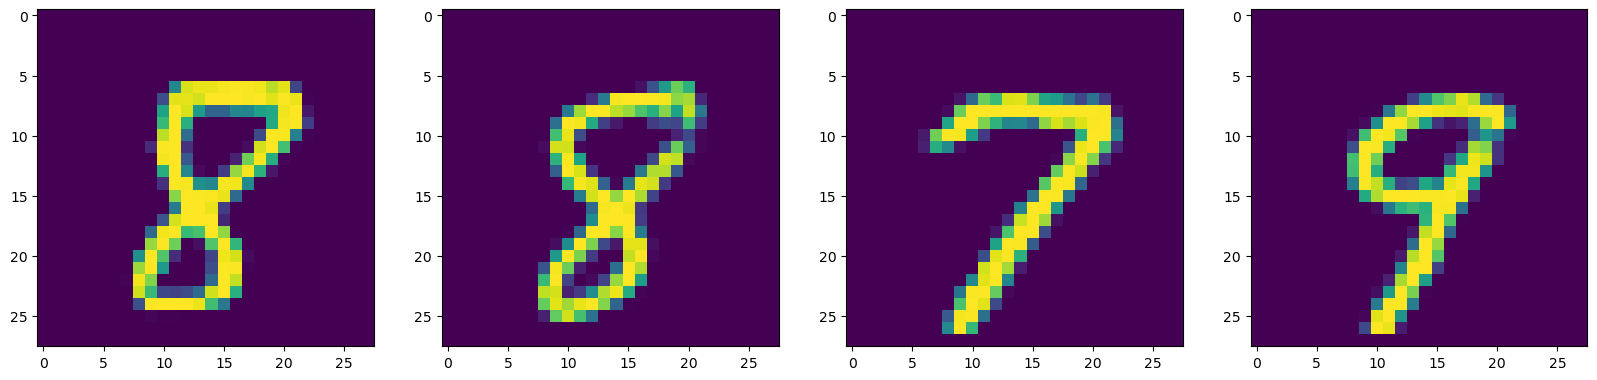

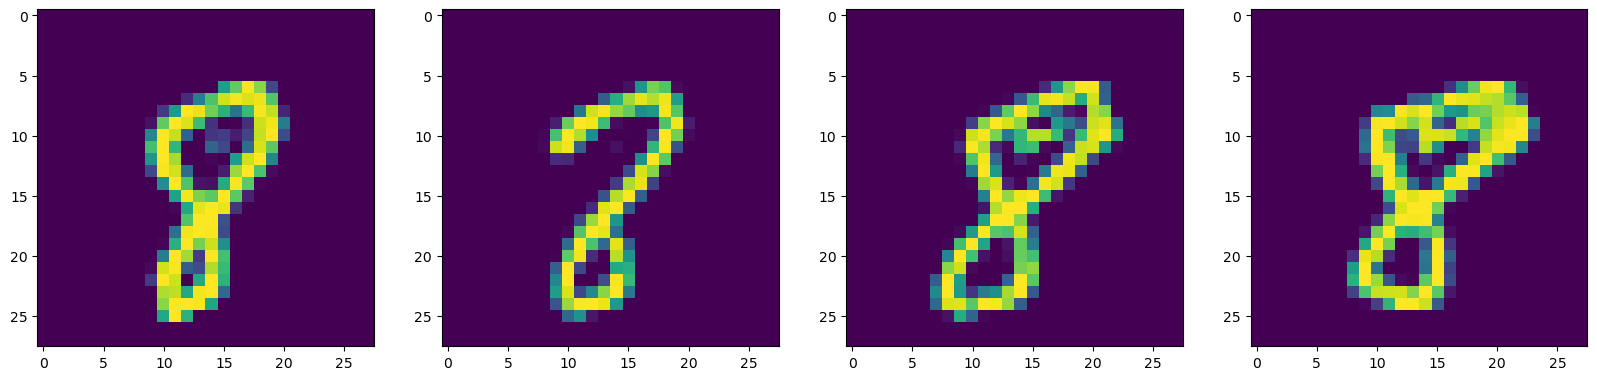

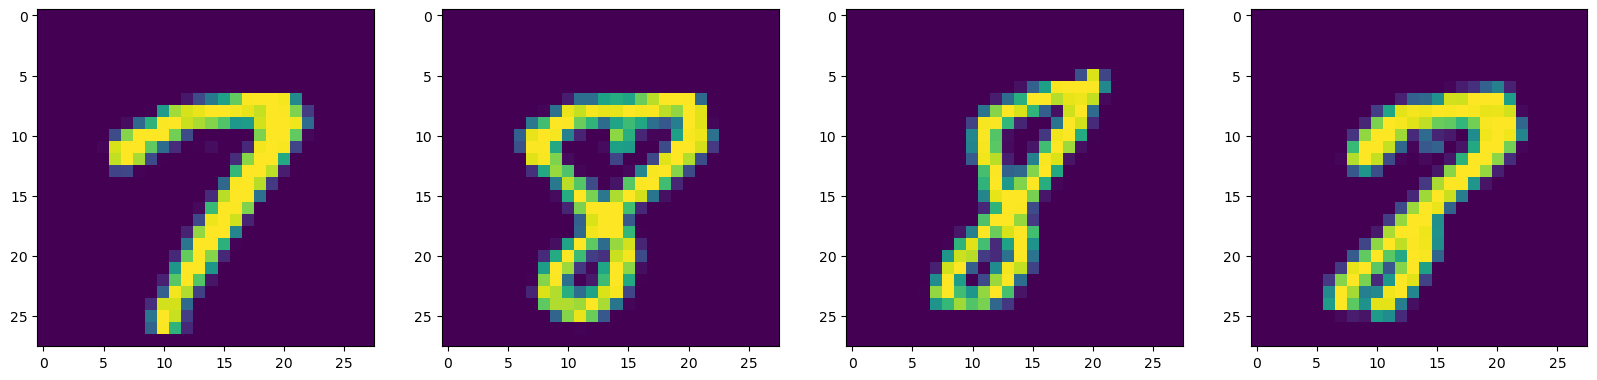

In [27]:
hist = gan.fit(ds, epochs=2000, callbacks=[ModelMonitor()])

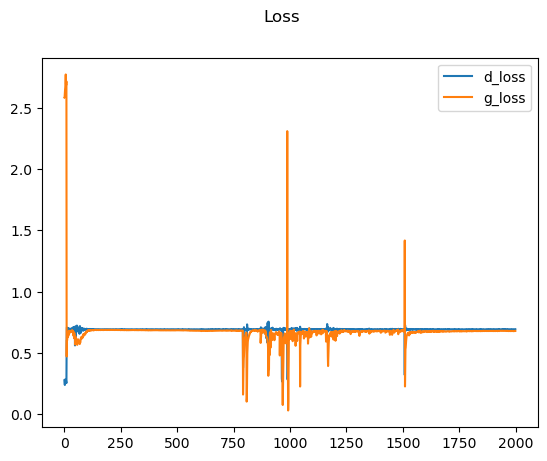

<Figure size 640x480 with 0 Axes>

In [28]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()
plt.savefig('images/training_loss.png')

# Checking model's performance

1/1 [==============================] - 0s 17ms/step


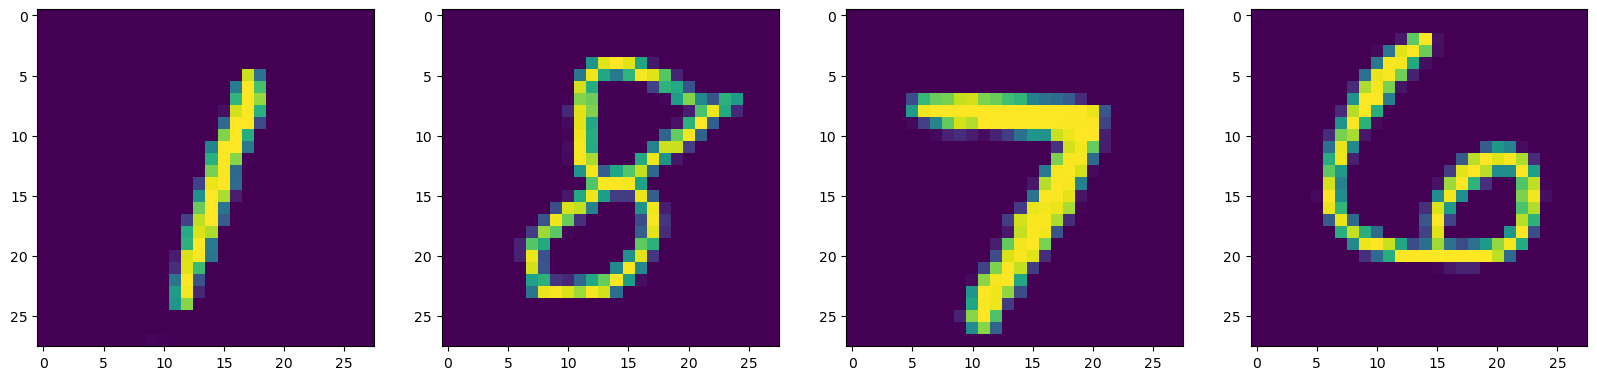

In [39]:
img = generator.predict(np.random.randn(4,100,1)) 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx, img in enumerate(img): 
    ax[idx].imshow(np.squeeze(img.reshape(28,28,1)))
    
plt.savefig('images/final_gen_images.png')

In [31]:
if not os.path.exists('models'):
    os.makedirs('models')

In [32]:
generator.save('models/Generator_Model')

INFO:tensorflow:Assets written to: models/Generator_Model\assets


INFO:tensorflow:Assets written to: models/Generator_Model\assets


In [33]:
discriminator.save('models/Discriminator_Model')

INFO:tensorflow:Assets written to: models/Discriminator_Model\assets


INFO:tensorflow:Assets written to: models/Discriminator_Model\assets
